## Compare LCSIF, CSIF, FLUXCOM and VIs against FLUXNET GPP
### Jianing Fang (jf3423@columbia.edu)

In [ ]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import linregress
import numpy as np
import os
from copy import deepcopy
from tqdm import tqdm
from datetime import datetime, date, timedelta
import datetime
from scipy.stats import ttest_ind, tukey_hsd, f_oneway, ttest_rel
import statsmodels.api as sm
from statsmodels.formula.api import ols

rcParams['font.family'] = 'Inter'
rcParams['font.size'] = 12
rcParams['figure.figsize'] = [5.0, 5.0]
rcParams['figure.dpi'] = 300
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

In [2]:
SITE_TWO_PERIODS = "../../data/vector/site_spanning_modis_and_avhrr_periods.csv"
meta_df = pd.read_csv(SITE_TWO_PERIODS).drop("Unnamed: 0", axis=1)
FLUXNET_DIR = "../../data/FLUXNET"
LCSIF_DIR = "../../data/processed/LCSIF_v2"
LCREF_DIR="LCSIF_reflectance_v1"
FLUXCOM_DIR = "../../data/FLUXCOM/"
ERA_5_CMG_LIST = [os.path.join("../../data/processed/ERA5_SSRD/CMG/", f) for f in sorted(os.listdir("../../data/processed/ERA5_SSRD/CMG")) if "DEFUNCT" not in f]

In [22]:
extracted_sif = []
extracted_sif_all = []
for year in tqdm(np.arange(1991, 2015)):
    year_list = sorted(os.listdir(os.path.join(LCSIF_DIR, str(year))))
    for file in year_list:
        ds = xr.open_dataset(os.path.join(LCSIF_DIR, str(year), file))
        sif_clear_daily = np.diag(ds.sif_clear_daily.sel(latitude = meta_df.LAT, longitude = meta_df.LON, method="nearest")[0].values)
        sif_all_daily = np.diag(ds.sif_all_daily.sel(latitude = meta_df.LAT, longitude = meta_df.LON, method="nearest")[0].values)
        extracted_sif.append(sif_clear_daily)
        extracted_sif_all.append(sif_all_daily)
site_sif = np.stack(extracted_sif)
site_sif_all = np.stack(extracted_sif_all)     

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [05:28<00:00, 13.70s/it]


In [23]:
extracted_red = []
extracted_nir = []

for year in tqdm(np.arange(1991, 2015)):
    year_list = sorted(os.listdir(os.path.join(LCREF_DIR, str(year))))
    for file in year_list:
        ds_red = xr.open_dataset(os.path.join(LCREF_DIR, str(year), file)).red
        ds_nir = xr.open_dataset(os.path.join(LCREF_DIR, str(year), file)).nir
        red_site = np.diag(ds_red.sel(latitude = meta_df.LAT, longitude = meta_df.LON, method="nearest")[0].values)
        nir_site = np.diag(ds_nir.sel(latitude = meta_df.LAT, longitude = meta_df.LON, method="nearest")[0].values)
        extracted_red.append(red_site)
        extracted_nir.append(nir_site)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [06:12<00:00, 15.52s/it]


In [24]:
extracted_ssrd = []
for file in ERA_5_CMG_LIST:
    ds_ssrd = np.flip(xr.open_dataset(file).Band1, axis=0)
    ssrd_site = np.diag(ds_ssrd.sel(lat = meta_df.LAT, lon = meta_df.LON, method="nearest").values)
    extracted_ssrd.append(ssrd_site)

In [25]:
site_ssrd = np.stack(extracted_ssrd[9*24:33*24])
np.save("../../data/processed/modis_avhrr_1991-2014_ssrd.npy", site_ssrd)

In [26]:
date_list = []
for year in np.arange(1991, 2015):
    for month in np.arange(1, 13):
        for day in [8, 22]:
            date_list.append(date(year, month, day))
dl = np.array(date_list)

In [27]:
site_red = np.stack(extracted_red)
site_nir = np.stack(extracted_nir)
site_ndvi = (site_nir - site_red) / (site_nir + site_red)
site_nirv = site_ndvi * site_nir
site_nirvp = site_nirv * site_ssrd
site_sigma = 0.5 * (site_red + site_nir)
site_kndvi = np.tanh(((site_nir-site_red) / (2 * site_sigma))**2)

In [28]:
np.save("../../data/processed/modis_avhrr_1991-2014_lcsif.npy", site_sif)
np.save("../../data/processed/modis_avhrr_1991-2014_lcsif_all.npy", site_sif_all)


In [29]:
np.save("../../data/processed/modis_avhrr_1991-2014_lcref_red.npy", site_red)
np.save("../../data/processed/modis_avhrr_1991-2014_lcref_nir.npy", site_nir)
np.save("../../data/processed/modis_avhrr_1991-2014_lcref_ndvi.npy", site_ndvi)
np.save("../../data/processed/modis_avhrr_1991-2014_lcref_nirv.npy", site_nirv)
np.save("../../data/processed/modis_avhrr_1991-2014_lcref_kndvi.npy", site_kndvi)
np.save("../../data/processed/modis_avhrr_1991-2014_lcref_nirvp.npy", site_nirvp)

In [30]:
site_sif = np.load("../../data/processed/modis_avhrr_1991-2014_lcsif.npy")
site_sif_all = np.load("../../data/processed/modis_avhrr_1991-2014_lcsif_all.npy")
site_red = np.load("../../data/processed/modis_avhrr_1991-2014_lcref_red.npy")
site_nir = np.load("../../data/processed/modis_avhrr_1991-2014_lcref_nir.npy")
site_ndvi = np.load("../../data/processed/modis_avhrr_1991-2014_lcref_ndvi.npy")
site_nirv = np.load("../../data/processed/modis_avhrr_1991-2014_lcref_nirv.npy")
site_kndvi = np.load("../../data/processed/modis_avhrr_1991-2014_lcref_kndvi.npy")
site_ssrd = np.load("../../data/processed/modis_avhrr_1991-2014_ssrd.npy")
site_nirvp = site_nirv * site_ssrd


date_list = []
for year in np.arange(1991, 2015):
    for month in np.arange(1, 13):
        for day in [8, 22]:
            date_list.append(date(year, month, day))
dl = np.array(date_list)

In [31]:
result_list=[]
for i in range(len(meta_df)):
    sitename =  meta_df["SITE_ID"][i]
    site_dir = os.path.join(FLUXNET_DIR, sitename)
    flux_df = pd.read_csv(os.path.join(site_dir, os.listdir(site_dir)[0]))
    
    GPP = deepcopy(flux_df.GPP_NT_VUT_REF)
    GPP[GPP==-9999]=np.nan
    GPP = pd.Series(GPP.values, index = pd.to_datetime(pd.to_datetime(flux_df.TIMESTAMP_START, format='%Y%m%d') + np.timedelta64(3, 'D'), format='%Y%m%d'))
    GPP = GPP.reindex(pd.date_range(str(meta_df.START[i])+"-01-01", str(np.minimum(meta_df.END[i], 2013))+"-12-31", freq="D")).interpolate(limit=7)
    
    FLUXCOM_GPP = xr.open_dataset(os.path.join(FLUXCOM_DIR, sitename + "_FLUXCOM_SUBSET.nc")).GPP.to_dataframe()["GPP"]
    FLUXCOM_GPP = FLUXCOM_GPP.reindex(pd.date_range(str(meta_df.START[i])+"-01-01", str(np.minimum(meta_df.END[i], 2013))+"-12-31", freq="D")).interpolate(limit=7)

    start_idx = np.argmax(dl > date(meta_df["START"][i], 1, 1))
    end_idx = np.argmax(dl > date(np.minimum(meta_df.END[i], 2013) + 1, 1, 1)) 
    if end_idx == 0:
        end_idx = len(dl)
    SIF_biweekly = site_sif[start_idx:end_idx, i]
    SIF_ALL_biweekly = site_sif_all[start_idx:end_idx, i]
    NDVI_biweekly = site_ndvi[start_idx:end_idx, i]
    NIRV_biweekly = site_nirv[start_idx:end_idx, i]
    NIRVP_biweekly = site_nirvp[start_idx:end_idx, i]
    KNDVI_biweekly = site_kndvi[start_idx:end_idx, i]
    
    DL = pd.to_datetime(dl[start_idx:end_idx])
    GPP_biweekly = GPP.reindex(DL)
    FLUXCOM_GPP_biweekly = FLUXCOM_GPP.reindex(DL)
    
    AVHRR = DL < np.datetime64("2001-01-01")
    MODIS = DL >= np.datetime64("2001-01-01")
    not_nan_sel_avhrr = np.invert(np.isnan(SIF_biweekly[AVHRR]) | np.isnan(GPP_biweekly[AVHRR]))
    not_nan_sel_modis = np.invert(np.isnan(SIF_biweekly[MODIS]) | np.isnan(GPP_biweekly[MODIS]))

    AVHRR_SIF_reg = linregress((SIF_biweekly[AVHRR])[not_nan_sel_avhrr], (GPP_biweekly[AVHRR])[not_nan_sel_avhrr])
    MODIS_SIF_reg = linregress((SIF_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis])
    result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"SIF", "R^2":AVHRR_SIF_reg.rvalue**2})
    result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"SIF", "R^2":MODIS_SIF_reg.rvalue**2})
    
    AVHRR_SIF_ALL_reg = linregress((SIF_ALL_biweekly[AVHRR])[not_nan_sel_avhrr], (GPP_biweekly[AVHRR])[not_nan_sel_avhrr])
    MODIS_SIF_ALL_reg = linregress((SIF_ALL_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis])
    result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"SIFALL", "R^2":AVHRR_SIF_ALL_reg.rvalue**2})
    result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"SIFALL", "R^2":MODIS_SIF_ALL_reg.rvalue**2})

    AVHRR_NDVI_reg = linregress((NDVI_biweekly[AVHRR])[not_nan_sel_avhrr], (GPP_biweekly[AVHRR])[not_nan_sel_avhrr])
    MODIS_NDVI_reg = linregress((NDVI_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis]) 
    result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"NDVI", "R^2":AVHRR_NDVI_reg.rvalue**2})
    result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"NDVI", "R^2":MODIS_NDVI_reg.rvalue**2})
    
    AVHRR_NIRV_reg = linregress((NIRV_biweekly[AVHRR])[not_nan_sel_avhrr], (GPP_biweekly[AVHRR])[not_nan_sel_avhrr])
    MODIS_NIRV_reg = linregress((NIRV_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis]) 
    result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"NIRV", "R^2":AVHRR_NIRV_reg.rvalue**2})
    result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"NIRV", "R^2":MODIS_NIRV_reg.rvalue**2})
    
    AVHRR_NIRVP_reg = linregress((NIRVP_biweekly[AVHRR])[not_nan_sel_avhrr], (GPP_biweekly[AVHRR])[not_nan_sel_avhrr])
    MODIS_NIRVP_reg = linregress((NIRVP_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis]) 
    result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"NIRVP", "R^2":AVHRR_NIRVP_reg.rvalue**2})
    result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"NIRVP", "R^2":MODIS_NIRVP_reg.rvalue**2})
    
    AVHRR_KNDVI_reg = linregress((KNDVI_biweekly[AVHRR])[not_nan_sel_avhrr], (GPP_biweekly[AVHRR])[not_nan_sel_avhrr])
    MODIS_KNDVI_reg = linregress((KNDVI_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis]) 
    result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"KNDVI", "R^2":AVHRR_KNDVI_reg.rvalue**2})
    result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"KNDVI", "R^2":MODIS_KNDVI_reg.rvalue**2})
    
    FLUXCOM_AVHRR_reg = linregress((FLUXCOM_GPP_biweekly[AVHRR])[not_nan_sel_avhrr], (GPP_biweekly[AVHRR])[not_nan_sel_avhrr])
    FLUXCOM_MODIS_reg = linregress((FLUXCOM_GPP_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis])
    result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"FLUXCOM", "R^2":FLUXCOM_AVHRR_reg.rvalue**2})
    result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"FLUXCOM", "R^2":FLUXCOM_MODIS_reg.rvalue**2})

In [32]:
result_df = pd.DataFrame(result_list)
result_df = pd.merge(result_df, meta_df, on="SITE_ID")

In [33]:
result_df_mean = result_df.groupby(["IGBP","sensor", "type"]).mean()["R^2"]
result_df_std = result_df.groupby(["IGBP","sensor", "type"]).mean()["R^2"]


In [34]:
result_df.to_csv("../../data/processed/r_modis_avhrr_fluxnet.csv", index=False)

In [35]:
meta_df["AVHRR_YEARS"] = 2001 - meta_df["START"] 
meta_df["MODIS_YEARS"] = np.minimum(meta_df["END"], 2013) - 2000

In [36]:
siteyear_df = meta_df.groupby("IGBP").sum()[["AVHRR_YEARS", "MODIS_YEARS"]]

In [37]:
siteyear_df.loc["DBF"]["AVHRR_YEARS"]

25

In [38]:
siteyear_df.loc["DBF"]["MODIS_YEARS"]

48

In [39]:
t_test_rest_list = []
for IGBP in ["ENF", "DBF", "MF"]:        
    for data_type in np.unique(result_df["type"].values):
        v1=result_df[(result_df["sensor"] == "AVHRR") & (result_df["IGBP"] == IGBP) & (result_df["type"] == data_type)]["R^2"].values
        v2=result_df[(result_df["sensor"] == "MODIS") & (result_df["IGBP"] == IGBP) & (result_df["type"] == data_type)]["R^2"].values
        t_res = ttest_rel(v1, v2, alternative="less")
        t_test_rest_list.append({"IGBP":IGBP, "type":data_type, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
t_test_df = pd.DataFrame(t_test_rest_list)
t_test_df.to_csv("../../data/processed/modis_avhrr_t_test.csv", index=False)

In [40]:
t_test_df

,IGBP,type,df,t,p
0,ENF,FLUXCOM,9,-1.888255,0.045796
1,ENF,KNDVI,9,-2.086631,0.033273
2,ENF,NDVI,9,-1.950278,0.041465
3,ENF,NIRV,9,-3.172110,0.005664
4,ENF,NIRVP,9,-1.887535,0.045848
5,ENF,SIF,9,-2.117682,0.031638
6,ENF,SIFALL,9,-2.121824,0.031426
7,DBF,FLUXCOM,3,-1.902707,0.076611
8,DBF,KNDVI,3,-11.460398,0.000713
9,DBF,NDVI,3,-8.694673,0.001601


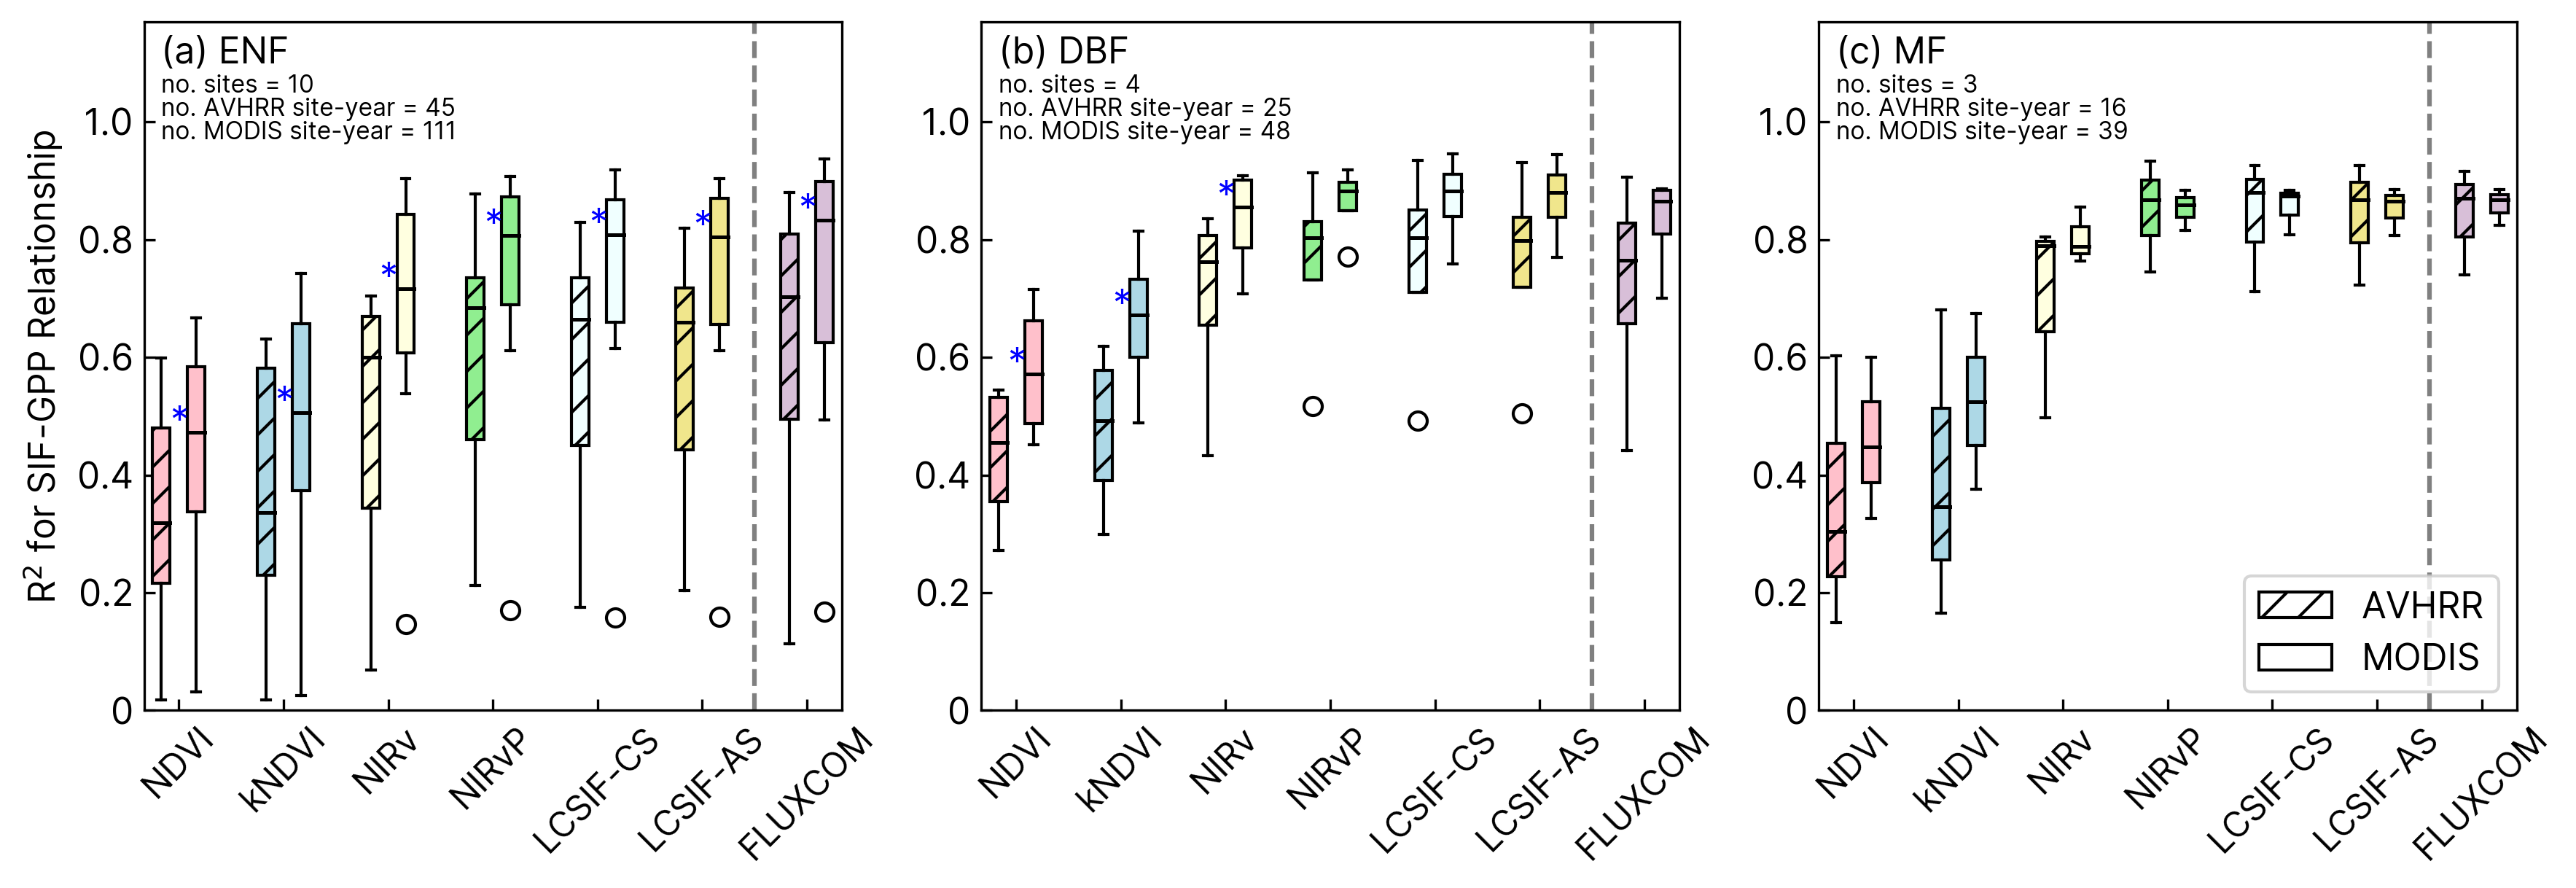

In [41]:
from matplotlib.patches import Patch
fig, axs = plt.subplots(1,3, figsize=(14,4.17), dpi=300)
ax = axs.flatten()
IGBP_types = ["ENF", "DBF", "MF"]
fig_labels = ["(a)", "(b)", "(c)"]
alpha = 0.05
for i in range(3):
    data=np.vstack([[result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["sensor"] == sensor) 
                             & (result_df["type"]=="NDVI")]["R^2"] for sensor in ["AVHRR", "MODIS"]],
                    [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["sensor"] == sensor) 
                             & (result_df["type"]=="KNDVI")]["R^2"] for sensor in ["AVHRR", "MODIS"]],
                  [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["sensor"] == sensor) 
                             & (result_df["type"]=="NIRV")]["R^2"] for sensor in ["AVHRR", "MODIS"]],
                    [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["sensor"] == sensor) 
                             & (result_df["type"]=="NIRVP")]["R^2"] for sensor in ["AVHRR", "MODIS"]],
                    [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["sensor"] == sensor) 
                             & (result_df["type"]=="SIF")]["R^2"] for sensor in ["AVHRR", "MODIS"]],
                    [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["sensor"] == sensor) 
                             & (result_df["type"]=="SIFALL")]["R^2"] for sensor in ["AVHRR", "MODIS"]],
                   [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["sensor"] == sensor) 
                             & (result_df["type"]=="FLUXCOM")]["R^2"] for sensor in ["AVHRR", "MODIS"]]]).T
    bplot = ax[i].boxplot(data, positions=[1,2,4,5,7,8,10,11,13,14,16,17,19,20], patch_artist=True)
    ax[i].set_ylim(0,1.17)
    colors = ['pink', 'pink', 'lightblue', 'lightblue', 'lightyellow', 'lightyellow', 'lightgreen', 'lightgreen', 'azure', 'azure', 'khaki', 'khaki', 'thistle', 'thistle']
    hatchs = ['//', '', '//', '', '//', '', '//', '', '//', '', '//', '', '//', '']
    ax[i].set_xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5], labels=["NDVI", "kNDVI", "NIRv", "NIRvP", "LCSIF-CS", "LCSIF-AS", "FLUXCOM"], fontsize=11.5, rotation=45)
    ax[i].text(1, 0.9+0.15, "no. sites = " + str(len(meta_df[meta_df["IGBP"]==IGBP_types[i]])), fontsize=8)
    ax[i].text(1, 0.86+0.15, "no. AVHRR site-year = " + str(siteyear_df.loc[IGBP_types[i]]["AVHRR_YEARS"]), fontsize=8)
    ax[i].text(1, 0.82+0.15, "no. MODIS site-year = " + str(siteyear_df.loc[IGBP_types[i]]["MODIS_YEARS"]), fontsize=8)
    ax[i].text(1,0.95+0.15, fig_labels[i] + " " + IGBP_types[i])
    ax[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
    data_types = ["NDVI", "KNDVI", "NIRV", "NIRVP", "SIF", "SIFALL", "FLUXCOM"]
    xloc=[1.25, 4.25, 7.25, 10.25, 13.25, 16.25, 19.25]
    for j in range(7):
        if t_test_df[(t_test_df["IGBP"]==IGBP_types[i]) & (t_test_df["type"]==data_types[j])]["p"].item() < alpha:
            yloc = np.median(result_df[(result_df["IGBP"]==IGBP_types[i]) & (result_df["sensor"] == "MODIS") & (result_df["type"]==data_types[j])]["R^2"])
            ax[i].text(xloc[j], yloc, "*", color="blue")

    for patch, color, hatch in zip(bplot['boxes'], colors, hatchs):
        patch.set_facecolor(color)
        patch.set_hatch(hatch)
    
    for median in bplot['medians']:
        median.set(color ='black',
                   linewidth = 1.2)
    if i == 0:
        ax[i].set_ylabel("R$^2$ for SIF-GPP Relationship")
        
    if i == 2:
        legend_elements = [Patch(facecolor='white', edgecolor='black', hatch="//",
                             label='AVHRR'),
                       Patch(facecolor='white', edgecolor='black', hatch="",
                             label='MODIS')]
        ax[i].legend(handles=legend_elements, loc='lower right')
        
    ax[i].plot([18,18], [0, 1.2], "--", c="grey")
    

plt.savefig("./figs/FLUXNET_MODIS_AVHRR_nirvp_all.png", dpi=300)

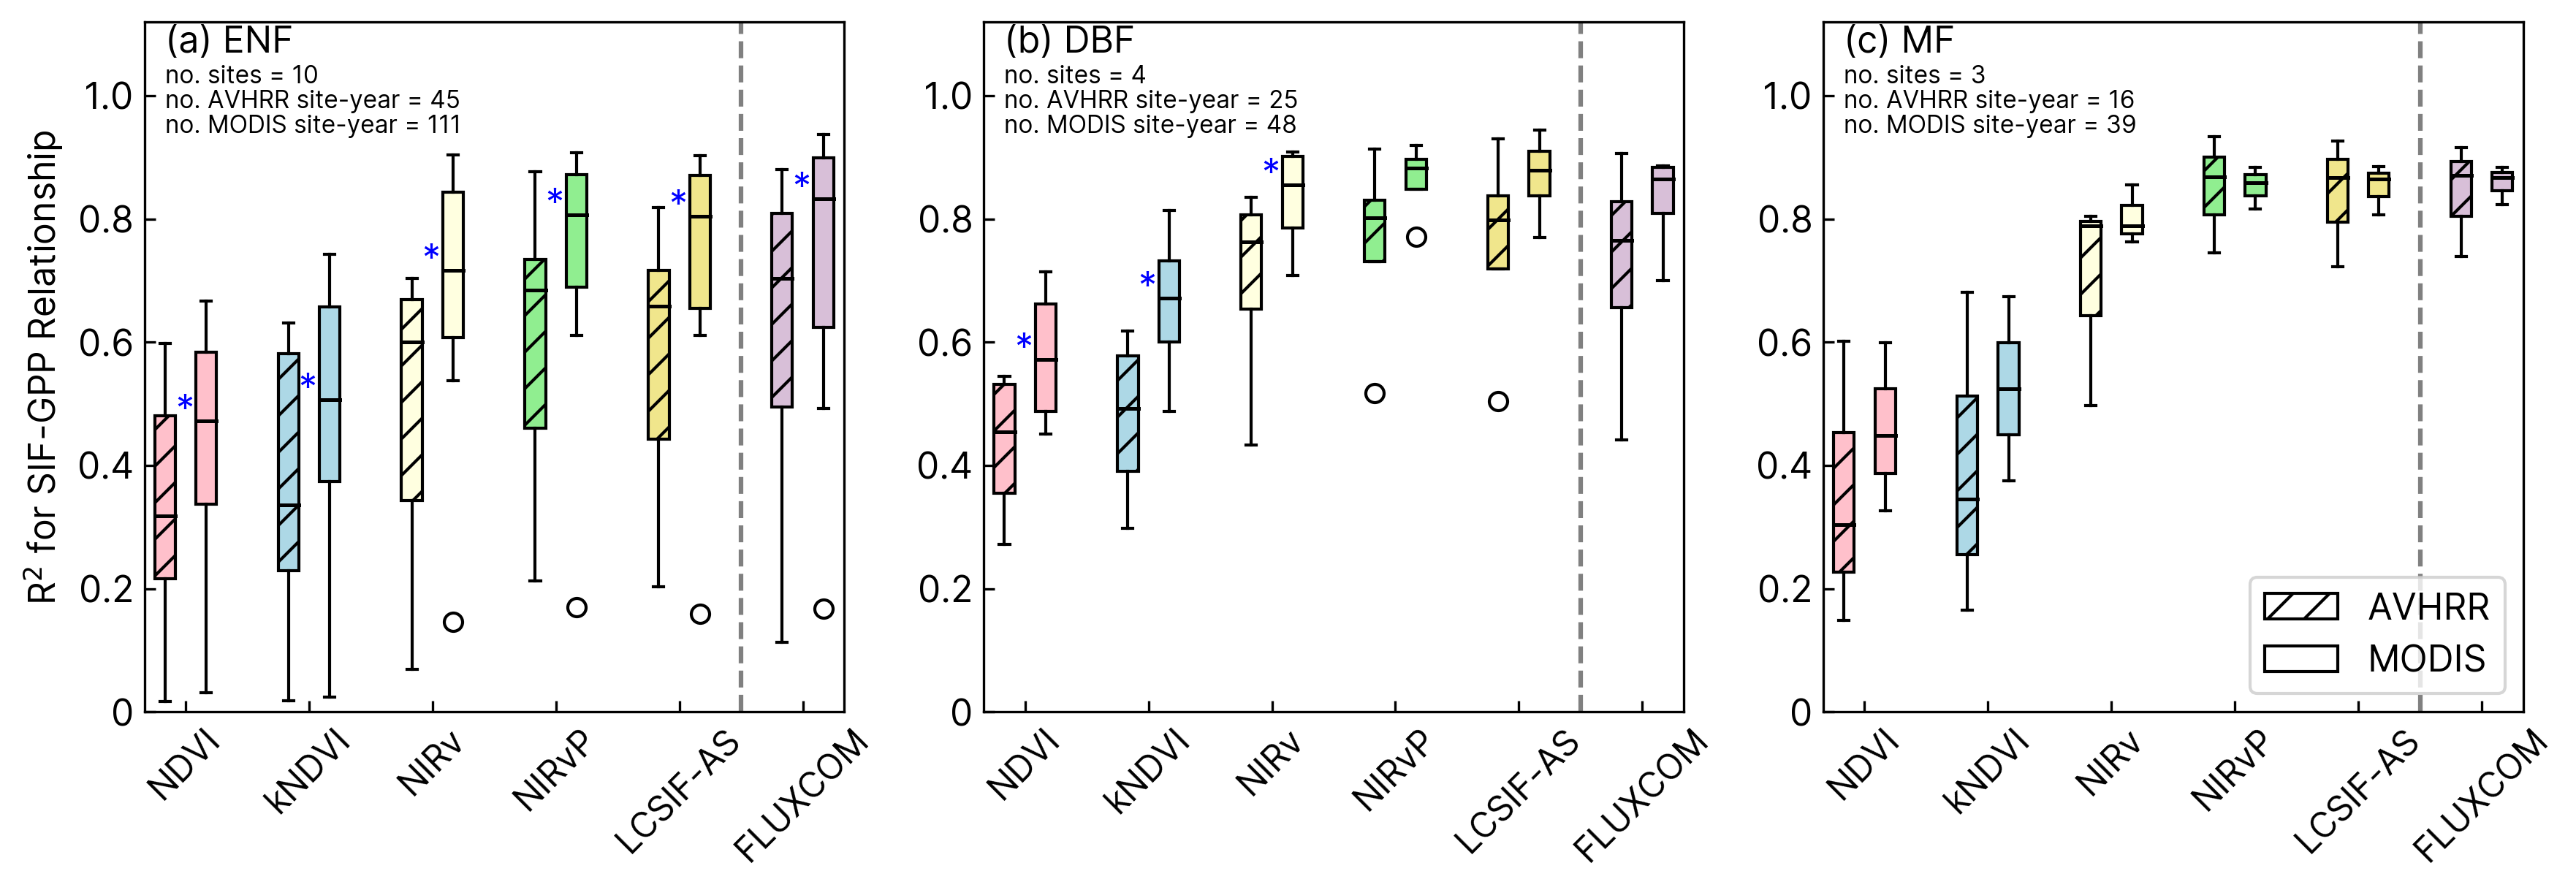

In [42]:
from matplotlib.patches import Patch
fig, axs = plt.subplots(1,3, figsize=(14,4.17), dpi=300)
ax = axs.flatten()
IGBP_types = ["ENF", "DBF", "MF"]
fig_labels = ["(a)", "(b)", "(c)"]
alpha = 0.05
for i in range(3):
    data=np.vstack([[result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["sensor"] == sensor) 
                             & (result_df["type"]=="NDVI")]["R^2"] for sensor in ["AVHRR", "MODIS"]],
                    [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["sensor"] == sensor) 
                             & (result_df["type"]=="KNDVI")]["R^2"] for sensor in ["AVHRR", "MODIS"]],
                  [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["sensor"] == sensor) 
                             & (result_df["type"]=="NIRV")]["R^2"] for sensor in ["AVHRR", "MODIS"]],
                    [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["sensor"] == sensor) 
                             & (result_df["type"]=="NIRVP")]["R^2"] for sensor in ["AVHRR", "MODIS"]],
                    [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["sensor"] == sensor) 
                             & (result_df["type"]=="SIFALL")]["R^2"] for sensor in ["AVHRR", "MODIS"]],
                   [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["sensor"] == sensor) 
                             & (result_df["type"]=="FLUXCOM")]["R^2"] for sensor in ["AVHRR", "MODIS"]]]).T
    bplot = ax[i].boxplot(data, positions=[1,2,4,5,7,8,10,11,13,14,16,17], patch_artist=True)
    ax[i].set_ylim(0,1.12)
    colors = ['pink', 'pink', 'lightblue', 'lightblue', 'lightyellow', 'lightyellow', 'lightgreen', 'lightgreen', 'khaki', 'khaki', 'thistle', 'thistle']
    hatchs = ['//', '', '//', '', '//', '', '//', '', '//', '', '//', '',]
    ax[i].set_xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5], labels=["NDVI", "kNDVI", "NIRv", "NIRvP", "LCSIF-AS", "FLUXCOM"], fontsize=11.5, rotation=45)
    ax[i].text(1, 0.9+0.12, "no. sites = " + str(len(meta_df[meta_df["IGBP"]==IGBP_types[i]])), fontsize=8)
    ax[i].text(1, 0.86+0.12, "no. AVHRR site-year = " + str(siteyear_df.loc[IGBP_types[i]]["AVHRR_YEARS"]), fontsize=8)
    ax[i].text(1, 0.82+0.12, "no. MODIS site-year = " + str(siteyear_df.loc[IGBP_types[i]]["MODIS_YEARS"]), fontsize=8)
    ax[i].text(1,0.95+0.12, fig_labels[i] + " " + IGBP_types[i])
    ax[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
    data_types = ["NDVI", "KNDVI", "NIRV", "NIRVP",  "SIFALL", "FLUXCOM"]
    xloc=[1.25, 4.25, 7.25, 10.25, 13.25, 16.25]
    for j in range(6):
        if t_test_df[(t_test_df["IGBP"]==IGBP_types[i]) & (t_test_df["type"]==data_types[j])]["p"].item() < alpha:
            yloc = np.median(result_df[(result_df["IGBP"]==IGBP_types[i]) & (result_df["sensor"] == "MODIS") & (result_df["type"]==data_types[j])]["R^2"])
            ax[i].text(xloc[j], yloc, "*", color="blue")

    for patch, color, hatch in zip(bplot['boxes'], colors, hatchs):
        patch.set_facecolor(color)
        patch.set_hatch(hatch)
    
    for median in bplot['medians']:
        median.set(color ='black',
                   linewidth = 1.2)
    if i == 0:
        ax[i].set_ylabel("R$^2$ for SIF-GPP Relationship")
        
    if i == 2:
        legend_elements = [Patch(facecolor='white', edgecolor='black', hatch="//",
                             label='AVHRR'),
                       Patch(facecolor='white', edgecolor='black', hatch="",
                             label='MODIS')]
        ax[i].legend(handles=legend_elements, loc='lower right')
        
    ax[i].plot([15,15], [0, 1.2], "--", c="grey")
    

plt.savefig("./figs/FLUXNET_MODIS_AVHRR_nirvp.png", dpi=300)

In [43]:
result_df

,SITE_ID,sensor,type,R^2,MAT,MAP,LAT,LON,IGBP,START,END
0,BE-Bra,AVHRR,SIF,0.925983,9.80,750.0,51.30761,4.51984,MF,1996,2014
1,BE-Bra,MODIS,SIF,0.808822,9.80,750.0,51.30761,4.51984,MF,1996,2014
2,BE-Bra,AVHRR,SIFALL,0.926393,9.80,750.0,51.30761,4.51984,MF,1996,2014
3,BE-Bra,MODIS,SIFALL,0.807318,9.80,750.0,51.30761,4.51984,MF,1996,2014
4,BE-Bra,AVHRR,NDVI,0.304481,9.80,750.0,51.30761,4.51984,MF,1996,2014
...,...,...,...,...,...,...,...,...,...,...,...
247,US-PFa,MODIS,NIRVP,0.859264,4.33,823.0,45.94590,-90.27230,MF,1995,2014
248,US-PFa,AVHRR,KNDVI,0.681052,4.33,823.0,45.94590,-90.27230,MF,1995,2014
249,US-PFa,MODIS,KNDVI,0.674473,4.33,823.0,45.94590,-90.27230,MF,1995,2014
250,US-PFa,AVHRR,FLUXCOM,0.870406,4.33,823.0,45.94590,-90.27230,MF,1995,2014


In [44]:
t_test_sif_clear_vs_vi = []
for IGBP in ["ENF", "DBF", "MF"]:        
    for sensor in ["MODIS", "AVHRR"]:
        for data_type in ["NDVI", "KNDVI","NIRV", "NIRVP", "SIFALL", "FLUXCOM"]:
            v1=result_df[(result_df["sensor"] == sensor) & (result_df["IGBP"] == IGBP) & (result_df["type"] == data_type)]["R^2"].values
            v2=result_df[(result_df["sensor"] == sensor) & (result_df["IGBP"] == IGBP) & (result_df["type"] == "SIF")]["R^2"].values
            if data_type == "FLUXCOM" or data_type == "NIRVP" or data_type == "SIFALL":
                t_res = ttest_rel(v1, v2)
            else:
                t_res = ttest_rel(v1, v2, alternative="less")
            if data_type == "SIFALL":
                t_test_sif_clear_vs_vi.append({"IGBP":IGBP, "LCSIF_clear vs.": "LCSIF_all", "sensor":sensor, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
            else:
                 t_test_sif_clear_vs_vi.append({"IGBP":IGBP, "LCSIF_clear vs.": data_type, "sensor":sensor, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
t_test_sif_clear_vs_vi_df = pd.DataFrame(t_test_sif_clear_vs_vi)

In [45]:
t_test_sif_clear_vs_vi_df

,IGBP,LCSIF_clear vs.,sensor,df,t,p
0,ENF,NDVI,MODIS,9,-4.927650,0.000408
1,ENF,KNDVI,MODIS,9,-3.958794,0.001655
2,ENF,NIRV,MODIS,9,-2.393097,0.020176
3,ENF,NIRVP,MODIS,9,0.430774,0.676766
4,ENF,LCSIF_all,MODIS,9,-0.917838,0.382642
5,ENF,FLUXCOM,MODIS,9,0.000301,0.999766
6,ENF,NDVI,AVHRR,9,-5.159470,0.000298
7,ENF,KNDVI,AVHRR,9,-4.307317,0.000985
8,ENF,NIRV,AVHRR,9,-3.747079,0.002288
9,ENF,NIRVP,AVHRR,9,1.423554,0.188305


In [46]:
t_test_sif_clear_vs_vi_df.to_csv("../../data/processed/lcsif_clear_to_vi_t_test_long_term_sites_only.csv", index=False)

In [47]:
t_test_sif_all_vs_vi = []
for IGBP in ["ENF", "DBF", "MF"]:        
    for sensor in ["MODIS", "AVHRR"]:
        for data_type in ["NDVI", "KNDVI","NIRV", "NIRVP", "SIF", "FLUXCOM"]:
            v1=result_df[(result_df["sensor"] == sensor) & (result_df["IGBP"] == IGBP) & (result_df["type"] == data_type)]["R^2"].values
            v2=result_df[(result_df["sensor"] == sensor) & (result_df["IGBP"] == IGBP) & (result_df["type"] == "SIFALL")]["R^2"].values
            if data_type == "FLUXCOM" or data_type == "NIRVP" or data_type == "SIF":
                t_res = ttest_rel(v1, v2)
            else:
                t_res = ttest_rel(v1, v2, alternative="less")
            if data_type == "SIF":
                t_test_sif_all_vs_vi.append({"IGBP":IGBP, "LCSIF_all vs.":"LCSIF_clear", "sensor":sensor, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
            else:
                t_test_sif_all_vs_vi.append({"IGBP":IGBP, "LCSIF_all vs.":data_type, "sensor":sensor, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
t_test_sif_all_vs_vi_df = pd.DataFrame(t_test_sif_all_vs_vi)

In [48]:
t_test_sif_all_vs_vi_df

,IGBP,LCSIF_all vs.,sensor,df,t,p
0,ENF,NDVI,MODIS,9,-4.593140,0.000652
1,ENF,KNDVI,MODIS,9,-3.669662,0.002579
2,ENF,NIRV,MODIS,9,-1.843011,0.049220
3,ENF,NIRVP,MODIS,9,1.733981,0.116952
4,ENF,LCSIF_clear,MODIS,9,0.917838,0.382642
5,ENF,FLUXCOM,MODIS,9,0.139476,0.892145
6,ENF,NDVI,AVHRR,9,-4.922317,0.000411
7,ENF,KNDVI,AVHRR,9,-4.057090,0.001427
8,ENF,NIRV,AVHRR,9,-3.226860,0.005187
9,ENF,NIRVP,AVHRR,9,3.403015,0.007836


In [49]:
t_test_sif_all_vs_vi_df.to_csv("../../data/processed/lcsif_all_to_vi_t_test_long_term_sites_only.csv", index=False)



## Now Look At All Sites

In [3]:
SITE_ALL = "../../data/vector/all_modis_period_fluxnet_sites.csv"
meta_df = pd.read_csv(SITE_ALL)
FLUXNET_DIR = "../../data/FLUXNET"
LCSIF_DIR = "../../data/processed/LCSIF_v2"
LCREF_DIR="LCSIF_reflectance_v1"

In [ ]:
extracted_sif = []
extracted_sif_all = []

for year in tqdm(np.arange(2001, 2015)):
    year_list = sorted(os.listdir(os.path.join(LCSIF_DIR, str(year))))
    for file in year_list:
        ds = xr.open_dataset(os.path.join(LCSIF_DIR, str(year), file))
        sif_clear_daily = np.diag(ds.sif_clear_daily.sel(latitude = meta_df.LAT, longitude = meta_df.LON, method="nearest")[0].values)
        extracted_sif.append(sif_clear_daily)
        sif_clear_all = np.diag(ds.sif_all_daily.sel(latitude = meta_df.LAT, longitude = meta_df.LON, method="nearest")[0].values)
        extracted_sif_all.append(sif_clear_all)
        
extracted_ssrd = []
for file in tqdm(ERA_5_CMG_LIST):
    ds_ssrd = np.flip(xr.open_dataset(file).Band1, axis=0)
    ssrd_site = np.diag(ds_ssrd.sel(lat = meta_df.LAT, lon = meta_df.LON, method="nearest").values)
    extracted_ssrd.append(ssrd_site)
    
site_sif = np.stack(extracted_sif)
site_sif_all = np.stack(extracted_sif_all)

np.save("../../data/processed/all_site_lcsif_2001_2020.npy", site_sif)
np.save("../../data/processed/all_site_lcsif_all_2001_2020.npy", site_sif_all)
site_ssrd = np.stack(extracted_ssrd[19*24:33*24])
np.save("../../data/processed/all_site_ssrd_2001_2020.npy", site_ssrd)

In [52]:
extracted_red = []
extracted_nir = []

for year in tqdm(np.arange(2001, 2015)):
    year_list = sorted(os.listdir(os.path.join(LCREF_DIR, str(year))))
    for file in year_list:
        ds_red = xr.open_dataset(os.path.join(LCREF_DIR, str(year), file)).red
        ds_nir = xr.open_dataset(os.path.join(LCREF_DIR, str(year), file)).nir
        red_site = np.diag(ds_red.sel(latitude = meta_df.LAT, longitude = meta_df.LON, method="nearest")[0].values)
        nir_site = np.diag(ds_nir.sel(latitude = meta_df.LAT, longitude = meta_df.LON, method="nearest")[0].values)
        extracted_red.append(red_site)
        extracted_nir.append(nir_site)
        
site_red = np.stack(extracted_red)
site_nir = np.stack(extracted_nir)
site_ndvi = (site_nir - site_red) / (site_nir + site_red)
site_nirv = site_ndvi * site_nir
site_sigma = 0.5 * (site_red + site_nir)
site_kndvi = np.tanh(((site_nir-site_red) / (2 * site_sigma))**2)

date_list = []
for year in np.arange(2001, 2015):
    for month in np.arange(1, 13):
        for day in [8, 22]:
            date_list.append(date(year, month, day))
dl = np.array(date_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [16:58<00:00, 72.78s/it]


In [53]:
np.save("../../data/processed/all_site_lcsif_2001_2020.npy", site_sif)
np.save("../../data/processed/all_site_red_2001_2020_name.npy", np.array(site_red))
np.save("../../data/processed/all_site_nir_2001_2020_name.npy", np.array(site_nir))
np.save("../../data/processed/all_site_ndvi_2001_2020_name.npy", np.array(site_ndvi))
np.save("../../data/processed/all_site_nirv_2001_2020_name.npy", np.array(site_nirv))
np.save("../../data/processed/all_site_kndvi_2001_2020_name.npy", np.array(site_kndvi))

In [54]:
CSIF_DIR = "../../data/CSIF_v2/"
extracted_csif = []
csif_file_list = []
for year in tqdm(np.arange(2001, 2021)):
    year_list = sorted(os.listdir(os.path.join(CSIF_DIR, str(year))))
    for file in year_list:
        ds = xr.open_dataset(os.path.join(CSIF_DIR, str(year), file)).clear_daily_SIF
        sif_clear_daily = np.diag(ds.sel(lat = meta_df.LAT, lon = meta_df.LON, method="nearest").values)
        extracted_csif.append(sif_clear_daily)
        csif_file_list.append(file)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [4:27:59<00:00, 803.99s/it]


In [55]:
np.save("../../data/processed/all_site_csif_2001_2020.npy", site_csif)
np.save("../../data/processed/all_site_csif_2001_2020_name.npy", np.array(csif_file_list))
np.save("../../data/processed/all_site_nirvp_2001_2020_name.npy", site_nirvp)

In [18]:
site_csif = np.load("../../data/processed/all_site_csif_2001_2020.npy")
csif_file_list = np.load("../../data/processed/all_site_csif_2001_2020_name.npy")

site_sif = np.load("../../data/processed/all_site_lcsif_2001_2020.npy")
site_sif_all =np.load("../../data/processed/all_site_lcsif_all_2001_2020.npy")

site_red = np.load("../../data/processed/all_site_red_2001_2020_name.npy")
site_nir = np.load("../../data/processed/all_site_nir_2001_2020_name.npy")
site_ndvi = np.load("../../data/processed/all_site_ndvi_2001_2020_name.npy")
site_nirv = np.load("../../data/processed/all_site_nirv_2001_2020_name.npy")
site_kndvi = np.load("../../data/processed/all_site_kndvi_2001_2020_name.npy")
site_nirvp = site_ssrd * site_nirv 
date_list = []
for year in np.arange(2001, 2015):
    for month in np.arange(1, 13):
        for day in [8, 22]:
            date_list.append(date(year, month, day))
dl = np.array(date_list)

In [20]:
csif_dl = []
for f in csif_file_list:
    date_str=f.split(".")[4]
    year = int(date_str[0:4])
    nday = int(date_str[4:])
    d = datetime.date(year,1,1) + timedelta(days=nday-1)
    csif_dl.append(d)

In [21]:
result_list=[]
for i in range(len(meta_df)):
    sitename =  meta_df["SITE_ID"][i]
    site_dir = os.path.join(FLUXNET_DIR, sitename)
    flux_df = pd.read_csv(os.path.join(site_dir, os.listdir(site_dir)[0]))
    
    GPP = deepcopy(flux_df.GPP_NT_VUT_REF)
    GPP[GPP==-9999]=np.nan
    GPP = pd.Series(GPP.values, index = pd.to_datetime(pd.to_datetime(flux_df.TIMESTAMP_START, format='%Y%m%d') + np.timedelta64(3, 'D'), format='%Y%m%d'))
    GPP = GPP.reindex(pd.date_range(str(flux_df.TIMESTAMP_START.iloc[0])[0:4]+"-01-01", str(flux_df.TIMESTAMP_START.iloc[-1])[0:4]+"-12-31", freq="D")).interpolate(limit=7)
    CSIF = pd.Series(site_csif[:, i], index=csif_dl).reindex(pd.date_range("2001-01-01", "2020-08-08", freq="D")).interpolate(limit=3)
    
    FLUXCOM_GPP = xr.open_dataset(os.path.join(FLUXCOM_DIR, sitename + "_FLUXCOM_SUBSET.nc")).GPP.to_dataframe()["GPP"]
    FLUXCOM_GPP = FLUXCOM_GPP.reindex(pd.date_range(str(flux_df.TIMESTAMP_START.iloc[0])[0:4]+"-01-01", str(flux_df.TIMESTAMP_START.iloc[-1])[0:4]+"-12-31", freq="D")).interpolate(limit=7)
    
    start_idx = np.argmax(dl > date(np.int64(str(flux_df.TIMESTAMP_START.iloc[0])[0:4]), 1, 1))
    end_idx = np.argmax(dl > date(np.int64(str(flux_df.TIMESTAMP_START.iloc[-1])[0:4]), 1, 1))
    if end_idx == 0:
        end_idx = len(dl)
    SIF_biweekly = site_sif[start_idx:end_idx, i]
    SIF_ALL_biweekly = site_sif_all[start_idx:end_idx, i]
    NDVI_biweekly = site_ndvi[start_idx:end_idx, i]
    NIRV_biweekly = site_nirv[start_idx:end_idx, i]
    NIRVP_biweekly = site_nirvp[start_idx:end_idx, i]

    KNDVI_biweekly = site_kndvi[start_idx:end_idx, i]
    
    DL = pd.to_datetime(dl[start_idx:end_idx])

    GPP_biweekly = GPP.reindex(DL)
    CSIF_biweekly = CSIF.reindex(DL)
    FLUXCOM_GPP_biweekly = FLUXCOM_GPP.reindex(DL)
    
    MODIS = DL >= np.datetime64("2001-01-01")
    not_nan_sel_modis = np.invert(np.isnan(SIF_biweekly[MODIS]) | np.isnan(GPP_biweekly[MODIS]))
    if np.sum(not_nan_sel_modis) > 0:
        MODIS_SIF_reg = linregress((SIF_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis])
        result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"LCSIF", "R^2":MODIS_SIF_reg.rvalue**2})
        
        MODIS_SIF_ALL_reg = linregress((SIF_ALL_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis])
        result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"LCSIF_ALL", "R^2":MODIS_SIF_ALL_reg.rvalue**2})

        MODIS_CSIF_reg = linregress((CSIF_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis])
        result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"CSIF", "R^2":MODIS_CSIF_reg.rvalue**2})
        
        MODIS_NDVI_reg = linregress((NDVI_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis]) 
        result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"LCREF_NDVI", "R^2":MODIS_NDVI_reg.rvalue**2})

        MODIS_NIRV_reg = linregress((NIRV_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis]) 
        result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"LCREF_NIRV", "R^2":MODIS_NIRV_reg.rvalue**2})
        
        MODIS_NIRVP_reg = linregress((NIRVP_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis]) 
        result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"LCREF_NIRVP", "R^2":MODIS_NIRVP_reg.rvalue**2})
        
        MODIS_KNDVI_reg = linregress((KNDVI_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis]) 
        result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"LCREF_KNDVI", "R^2":MODIS_NIRV_reg.rvalue**2})
        
        try:
            MODIS_FLUXCOM_GPP_reg = linregress((FLUXCOM_GPP_biweekly[MODIS])[not_nan_sel_modis], (GPP_biweekly[MODIS])[not_nan_sel_modis]) 
            result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"FLUXCOM", "R^2":MODIS_FLUXCOM_GPP_reg.rvalue**2})
        except ValueError:
            result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"FLUXCOM", "R^2":np.nan})

In [22]:
result_all_df = pd.DataFrame(result_list)
result_all_df = pd.merge(result_all_df, meta_df, on="SITE_ID")

In [23]:
result_all_df

,SITE_ID,sensor,type,R^2,LAT,LON,IGBP
0,AR-SLu,MODIS,LCSIF,0.343431,-33.4648,-66.4598,MF
1,AR-SLu,MODIS,LCSIF_ALL,0.377659,-33.4648,-66.4598,MF
2,AR-SLu,MODIS,CSIF,0.256573,-33.4648,-66.4598,MF
3,AR-SLu,MODIS,LCREF_NDVI,0.045933,-33.4648,-66.4598,MF
4,AR-SLu,MODIS,LCREF_NIRV,0.210161,-33.4648,-66.4598,MF
...,...,...,...,...,...,...,...
1491,ZM-Mon,MODIS,LCREF_NDVI,0.333685,-15.4391,23.2525,DBF
1492,ZM-Mon,MODIS,LCREF_NIRV,0.382785,-15.4391,23.2525,DBF
1493,ZM-Mon,MODIS,LCREF_NIRVP,0.271356,-15.4391,23.2525,DBF
1494,ZM-Mon,MODIS,LCREF_KNDVI,0.382785,-15.4391,23.2525,DBF


In [24]:
result_all_df_mean = result_all_df.groupby(["IGBP", "type"]).mean()
result_all_df_mean = result_all_df.groupby(["IGBP", "type"]).std()

/tmp/ipykernel_337626/3042718675.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result_all_df_mean = result_all_df.groupby(["IGBP", "type"]).mean()
/tmp/ipykernel_337626/3042718675.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result_all_df_mean = result_all_df.groupby(["IGBP", "type"]).std()


In [ ]:
result_all_df.to_csv("../../data/processed/all_sites_r.csv", index=False)

In [25]:
# drop to DBF sites with nan values
result_all_df = result_all_df[(result_all_df["SITE_ID"] != "US-UMB")]
result_all_df = result_all_df[(result_all_df["SITE_ID"] != "US-UMd")]

In [ ]:
t_test_lcsif_clear_vs_vi_all = []
for IGBP in np.unique(result_all_df["IGBP"].values):        
        for data_type in ["LCREF_NDVI", "LCREF_KNDVI", "LCREF_NIRV", "LCREF_NIRVP", "CSIF", "LCSIF_ALL", "FLUXCOM"]:
            v1=result_all_df[(result_all_df["IGBP"] == IGBP) & (result_all_df["type"] == data_type)]["R^2"].values
            v2=result_all_df[(result_all_df["IGBP"] == IGBP) & (result_all_df["type"] == "LCSIF")]["R^2"].values
            if data_type == "CSIF" or data_type == "FLUXCOM" or data_type == "LCREF_NIRVP" or data_type == "LCSIF_ALL":
                t_res = ttest_rel(v1, v2)
            else:
                t_res = ttest_rel(v1, v2, alternative="less")
            t_test_lcsif_clear_vs_vi_all.append({"IGBP":IGBP, "LCSIF_clear vs.":data_type, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
t_test_lcsif_clear_vs_vi_all_df = pd.DataFrame(t_test_lcsif_clear_vs_vi_all)

In [27]:
t_test_lcsif_clear_vs_vi_all_df

,IGBP,LCSIF_clear vs.,df,t,p
0,CRO,LCREF_NDVI,15,-6.415597,0.000006
1,CRO,LCREF_KNDVI,15,-3.097272,0.003679
2,CRO,LCREF_NIRV,15,-3.097272,0.003679
3,CRO,LCREF_NIRVP,15,-0.307886,0.762403
4,CRO,CSIF,15,-0.828506,0.420372
...,...,...,...,...,...
79,WSA,LCREF_NIRV,5,-2.357822,0.032463
80,WSA,LCREF_NIRVP,5,-0.623314,0.560406
81,WSA,CSIF,5,-1.020120,0.354466
82,WSA,LCSIF_ALL,5,0.523397,0.623058


In [ ]:
t_test_lcsif_clear_vs_vi_all_df.to_csv("../../data/processed/all_sites_lcsif_clear_tovi_ttest.csv", index=False)

In [ ]:
t_test_lcsif_all_vs_vi_all = []
for IGBP in np.unique(result_all_df["IGBP"].values):        
        for data_type in ["LCREF_NDVI", "LCREF_KNDVI", "LCREF_NIRV", "LCREF_NIRVP", "LCSIF", "CSIF", "FLUXCOM"]:
            v1=result_all_df[(result_all_df["IGBP"] == IGBP) & (result_all_df["type"] == data_type)]["R^2"].values
            v2=result_all_df[(result_all_df["IGBP"] == IGBP) & (result_all_df["type"] == "LCSIF_ALL")]["R^2"].values
            if data_type == "CSIF" or data_type == "FLUXCOM" or data_type == "LCREF_NIRVP" or data_type =="LCSIF":
                t_res = ttest_rel(v1, v2)
            else:
                t_res = ttest_rel(v1, v2, alternative="less")
            if data_type == "LCSIF":
                t_test_lcsif_all_vs_vi_all.append({"IGBP":IGBP, "LCSIF_all vs.":"LCSIF_clear", "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
            else:
                t_test_lcsif_all_vs_vi_all.append({"IGBP":IGBP, "LCSIF_all vs.":data_type, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
t_test_lcsif_all_vs_vi_all_df = pd.DataFrame(t_test_lcsif_all_vs_vi_all)

In [29]:
t_test_lcsif_all_vs_vi_all_df

,IGBP,LCSIF_all vs.,df,t,p
0,CRO,LCREF_NDVI,15,-5.962097,0.000013
1,CRO,LCREF_KNDVI,15,-2.911741,0.005368
2,CRO,LCREF_NIRV,15,-2.911741,0.005368
3,CRO,LCREF_NIRVP,15,-2.063425,0.056824
4,CRO,LCSIF_clear,15,-1.506044,0.152823
...,...,...,...,...,...
79,WSA,LCREF_NIRV,5,-2.366907,0.032099
80,WSA,LCREF_NIRVP,5,-1.140757,0.305647
81,WSA,LCSIF_clear,5,-0.523397,0.623058
82,WSA,CSIF,5,-1.113556,0.316118


In [ ]:
t_test_lcsif_all_vs_vi_all_df.to_csv("../../data/processed/all_sites_lcsif_all_tovi_ttest.csv", index=False)

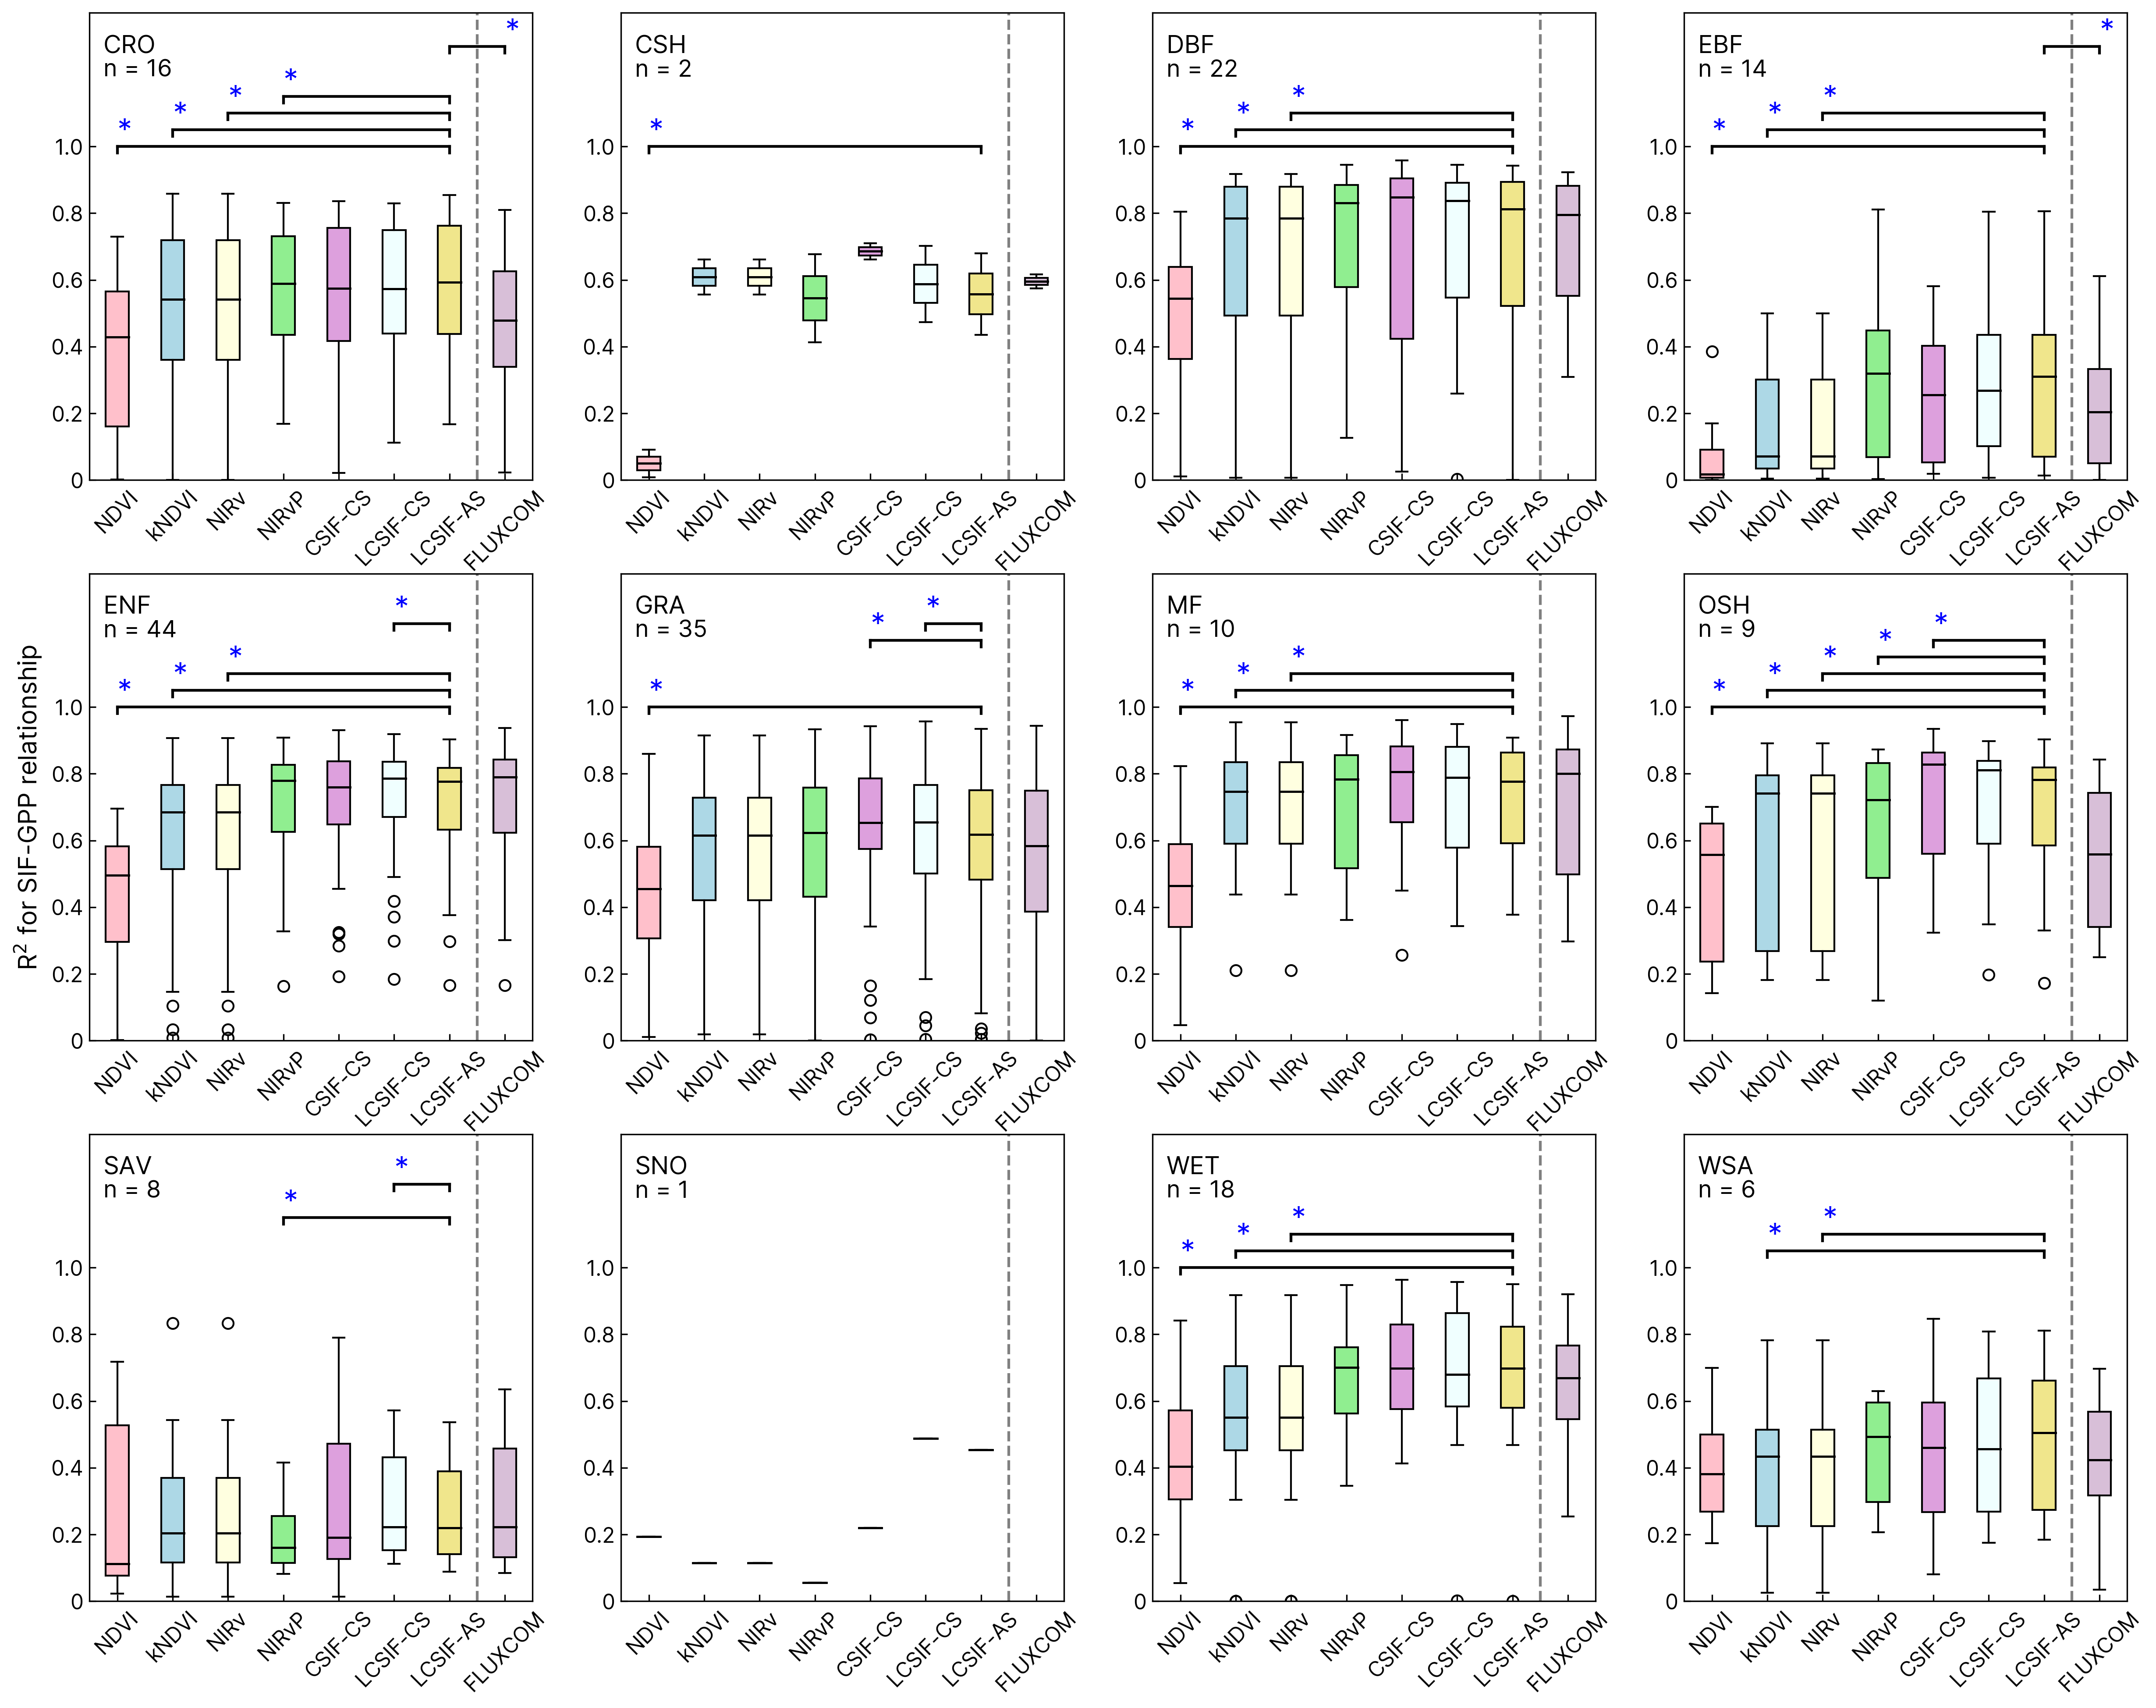

In [30]:
def plot_bar(axis, x1, x2, y_loc):
    axis.plot([x1,x2], [y_loc, y_loc], c="k")
    axis.plot([x1,x1], [y_loc, y_loc-0.02], c="k")
    axis.plot([x2,x2], [y_loc, y_loc-0.02], c="k")
        

from matplotlib.patches import Patch
fig, axs = plt.subplots(3,4, figsize=(20,16), dpi=300)
ax = axs.flatten()
IGBP_types = np.unique(result_all_df["IGBP"])
for i in range(len(IGBP_types)):
    p = [1,2.2,3.4,4.6,5.8,7.0,8.2,9.4]
    data=np.vstack([[result_all_df[(result_all_df["IGBP"]==IGBP_types[i]) 
                             & (result_all_df["type"]==t)]["R^2"] for t in ["LCREF_NDVI", "LCREF_KNDVI", "LCREF_NIRV", "LCREF_NIRVP", "CSIF", "LCSIF", "LCSIF_ALL", "FLUXCOM"]]]).T
    bplot = ax[i].boxplot(data, positions=p, patch_artist=True)
    ax[i].set_xlim(0.4,10)
    colors = ['pink', 'lightblue', 'lightyellow', 'lightgreen',  'plum', 'azure', 'khaki', 'thistle']
    hatchs = ['', '', '', '', '', '', '', '']
    ax[i].set_xticks(p, labels=["NDVI", "kNDVI", "NIRv", "NIRvP", "CSIF-CS", "LCSIF-CS", "LCSIF-AS", "FLUXCOM"], fontsize=13.5, rotation=45)
    ax[i].tick_params(axis='both', which='major', labelsize=11.5)

    ax[i].text(0.7, 0.93+0.35, IGBP_types[i], fontsize=13.5)
    ax[i].text(0.7, 0.86+0.35, "n = " + str(len(np.unique(result_all_df[result_all_df["IGBP"]==IGBP_types[i]]["SITE_ID"]))), fontsize=13)
    ax[i].set_ylim(0, 1.4)
    ax[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
    
    alpha = 0.1
    if t_test_lcsif_all_vs_vi_all_df[(t_test_lcsif_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcsif_all_vs_vi_all_df["LCSIF_all vs."]=="LCREF_NDVI")]["p"].values.item() < alpha:
        plot_bar(ax[i], p[0], p[6], 1.0)
        ax[i].text(p[0], 1.02, "*", c="blue", fontsize=16)
    if t_test_lcsif_all_vs_vi_all_df[(t_test_lcsif_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcsif_all_vs_vi_all_df["LCSIF_all vs."]=="LCREF_KNDVI")]["p"].values.item() < alpha:
        plot_bar(ax[i], p[1], p[6], 1.05)
        ax[i].text(p[1], 1.05+0.02, "*", c="blue", fontsize=16)
    if t_test_lcsif_all_vs_vi_all_df[(t_test_lcsif_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcsif_all_vs_vi_all_df["LCSIF_all vs."]=="LCREF_NIRV")]["p"].values.item() < alpha:
        plot_bar(ax[i], p[2], p[6], 1.1)
        ax[i].text(p[2], 1.1+0.02, "*", c="blue", fontsize=16)
    if t_test_lcsif_all_vs_vi_all_df[(t_test_lcsif_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcsif_all_vs_vi_all_df["LCSIF_all vs."]=="LCREF_NIRVP")]["p"].values.item() < alpha:
        plot_bar(ax[i], p[3], p[6], 1.15)
        ax[i].text(p[3], 1.15+0.02, "*", c="blue", fontsize=16)
    if t_test_lcsif_all_vs_vi_all_df[(t_test_lcsif_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcsif_all_vs_vi_all_df["LCSIF_all vs."]=="CSIF")]["p"].values.item() < alpha:
        plot_bar(ax[i], p[4], p[6], 1.2)
        ax[i].text(p[4], 1.2+0.02, "*", c="blue", fontsize=16)
    if t_test_lcsif_all_vs_vi_all_df[(t_test_lcsif_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcsif_all_vs_vi_all_df["LCSIF_all vs."]=="LCSIF_clear")]["p"].values.item() < alpha:
        plot_bar(ax[i], p[5], p[6], 1.25)
        ax[i].text(p[5], 1.25+0.02, "*", c="blue", fontsize=16)
    if t_test_lcsif_all_vs_vi_all_df[(t_test_lcsif_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcsif_all_vs_vi_all_df["LCSIF_all vs."]=="FLUXCOM")]["p"].values.item() < alpha:
        plot_bar(ax[i], p[7], p[6], 1.3)
        ax[i].text(p[7], 1.3+0.02, "*", c="blue", fontsize=16)

    
    if i == 4:
        ax[i].set_ylabel("R$^2$ for SIF-GPP relationship", fontsize=14)
    for median in bplot['medians']:
        median.set(color ='black',
                   linewidth = 1.2)
    
    for patch, color, hatch in zip(bplot['boxes'], colors, hatchs):
        patch.set_facecolor(color)
        patch.set_hatch(hatch)
        
    ax[i].plot([8.8,8.8], [0,2], "--", c="grey")
plt.savefig("./figs/FLUXNET_MODIS_PERIOD_ALL_nirvp_all_compared_with_all_sky.png", dpi=300)

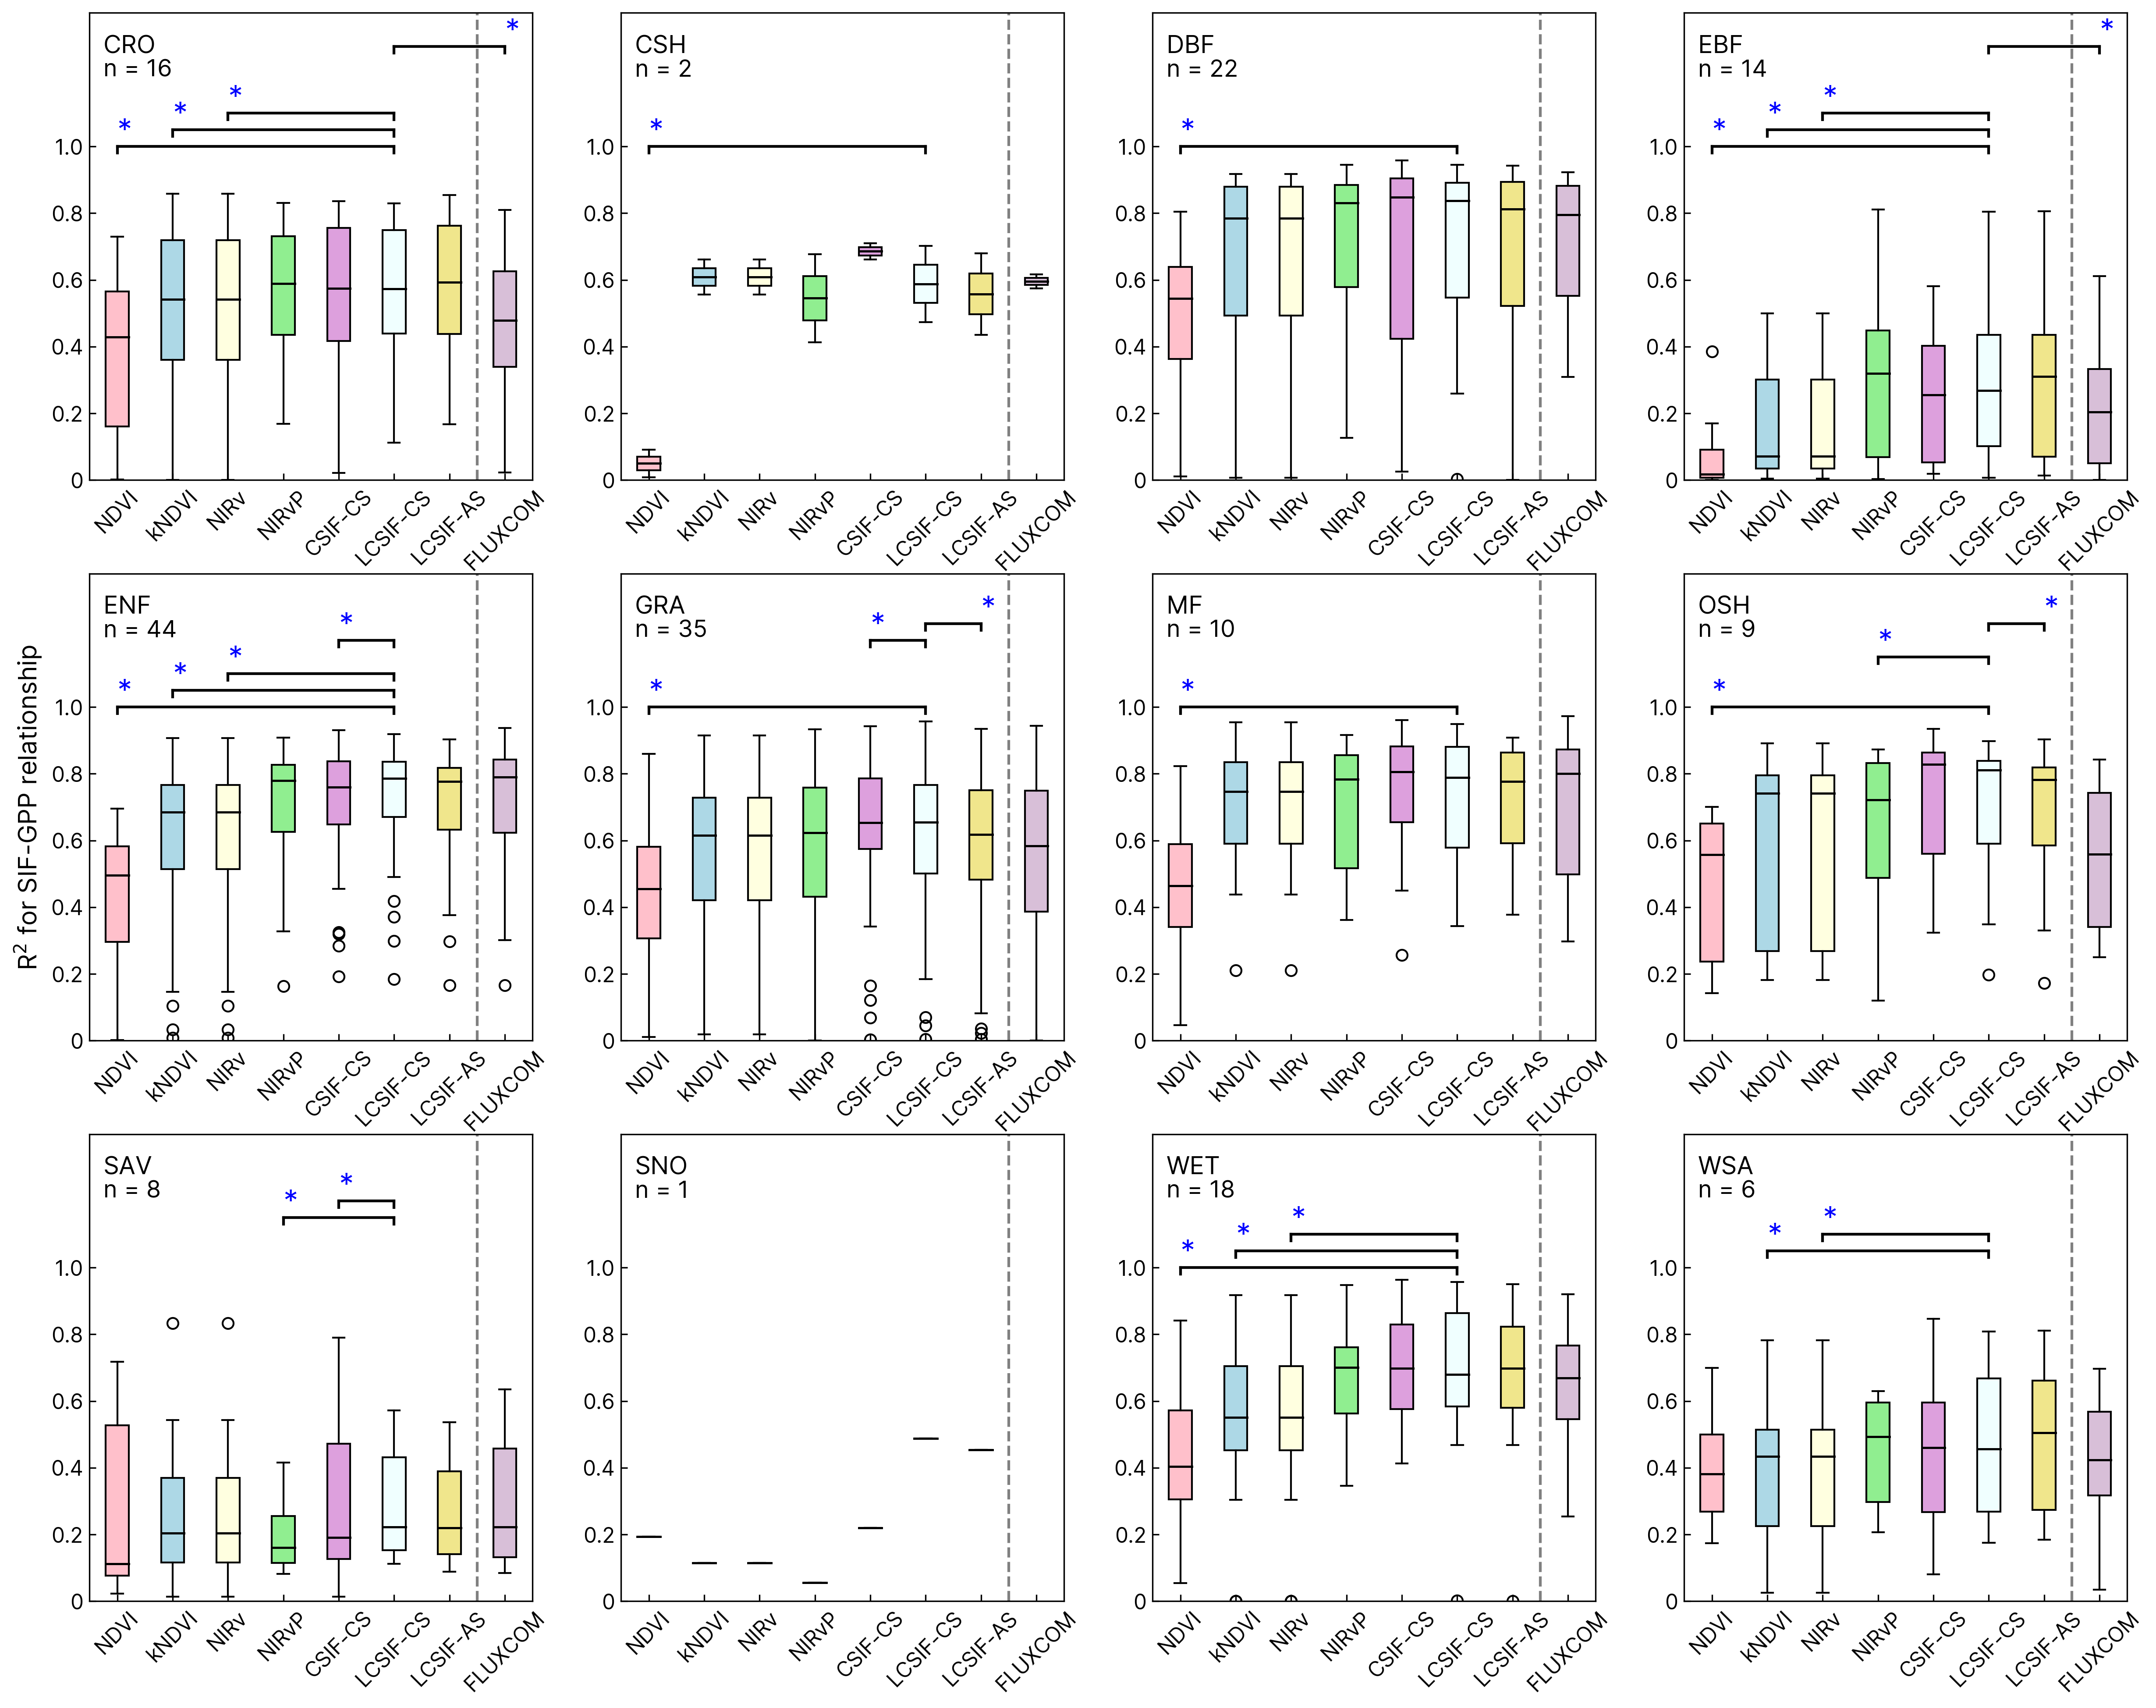

In [31]:
def plot_bar(axis, x1, x2, y_loc):
    axis.plot([x1,x2], [y_loc, y_loc], c="k")
    axis.plot([x1,x1], [y_loc, y_loc-0.02], c="k")
    axis.plot([x2,x2], [y_loc, y_loc-0.02], c="k")
        

from matplotlib.patches import Patch
fig, axs = plt.subplots(3,4, figsize=(20,16), dpi=300)
ax = axs.flatten()
IGBP_types = np.unique(result_all_df["IGBP"])

alpha = 0.05
for i in range(len(IGBP_types)):
    p = [1,2.2,3.4,4.6,5.8,7.0,8.2,9.4]
    data=np.vstack([[result_all_df[(result_all_df["IGBP"]==IGBP_types[i]) 
                             & (result_all_df["type"]==t)]["R^2"] for t in ["LCREF_NDVI", "LCREF_KNDVI", "LCREF_NIRV", "LCREF_NIRVP", "CSIF", "LCSIF", "LCSIF_ALL", "FLUXCOM"]]]).T
    bplot = ax[i].boxplot(data, positions=p, patch_artist=True)
    ax[i].set_xlim(0.4,10)
    colors = ['pink', 'lightblue', 'lightyellow', 'lightgreen',  'plum', 'azure', 'khaki', 'thistle']
    hatchs = ['', '', '', '', '', '', '', '']
    ax[i].set_xticks(p, labels=["NDVI", "kNDVI", "NIRv", "NIRvP", "CSIF-CS", "LCSIF-CS", "LCSIF-AS", "FLUXCOM"], fontsize=13.5, rotation=45)
    ax[i].tick_params(axis='both', which='major', labelsize=11.5)

    ax[i].text(0.7, 0.93+0.35, IGBP_types[i], fontsize=13.5)
    ax[i].text(0.7, 0.86+0.35, "n = " + str(len(np.unique(result_all_df[result_all_df["IGBP"]==IGBP_types[i]]["SITE_ID"]))), fontsize=13)
    ax[i].set_ylim(0, 1.4)
    ax[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
    
    if t_test_lcsif_all_vs_vi_all_df[(t_test_lcsif_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcsif_clear_vs_vi_all_df["LCSIF_clear vs."]=="LCREF_NDVI")]["p"].values.item() < alpha:
        plot_bar(ax[i], p[0], p[5], 1.0)
        ax[i].text(p[0], 1.02, "*", c="blue", fontsize=16)
    if t_test_lcsif_all_vs_vi_all_df[(t_test_lcsif_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcsif_clear_vs_vi_all_df["LCSIF_clear vs."]=="LCREF_KNDVI")]["p"].values.item() < alpha:
        plot_bar(ax[i], p[1], p[5], 1.05)
        ax[i].text(p[1], 1.05+0.02, "*", c="blue", fontsize=16)
    if t_test_lcsif_all_vs_vi_all_df[(t_test_lcsif_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcsif_clear_vs_vi_all_df["LCSIF_clear vs."]=="LCREF_NIRV")]["p"].values.item() < alpha:
        plot_bar(ax[i], p[2], p[5], 1.1)
        ax[i].text(p[2], 1.1+0.02, "*", c="blue", fontsize=16)
    if t_test_lcsif_all_vs_vi_all_df[(t_test_lcsif_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcsif_clear_vs_vi_all_df["LCSIF_clear vs."]=="LCREF_NIRVP")]["p"].values.item() < alpha:
        plot_bar(ax[i], p[3], p[5], 1.15)
        ax[i].text(p[3], 1.15+0.02, "*", c="blue", fontsize=16)
    if t_test_lcsif_all_vs_vi_all_df[(t_test_lcsif_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcsif_clear_vs_vi_all_df["LCSIF_clear vs."]=="CSIF")]["p"].values.item() < alpha:
        plot_bar(ax[i], p[4], p[5], 1.2)
        ax[i].text(p[4], 1.2+0.02, "*", c="blue", fontsize=16)
    if t_test_lcsif_all_vs_vi_all_df[(t_test_lcsif_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcsif_clear_vs_vi_all_df["LCSIF_clear vs."]=="LCSIF_ALL")]["p"].values.item() < alpha:
        plot_bar(ax[i], p[6], p[5], 1.25)
        ax[i].text(p[6], 1.25+0.02, "*", c="blue", fontsize=16)
    if t_test_lcsif_all_vs_vi_all_df[(t_test_lcsif_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcsif_clear_vs_vi_all_df["LCSIF_clear vs."]=="FLUXCOM")]["p"].values.item() < alpha:
        plot_bar(ax[i], p[7], p[5], 1.3)
        ax[i].text(p[7], 1.3+0.02, "*", c="blue", fontsize=16)

    
    if i == 4:
        ax[i].set_ylabel("R$^2$ for SIF-GPP relationship", fontsize=14)
    for median in bplot['medians']:
        median.set(color ='black',
                   linewidth = 1.2)
    
    for patch, color, hatch in zip(bplot['boxes'], colors, hatchs):
        patch.set_facecolor(color)
        patch.set_hatch(hatch)
        
    ax[i].plot([8.8, 8.8], [0,2], "--", c="grey")
plt.savefig("./figs/FLUXNET_MODIS_PERIOD_ALL_nirvp_all_compared_with_clear_sky.png", dpi=300)